<a href="https://colab.research.google.com/github/Martinmbiro/XO-binary-classification/blob/main/02%20XO%20end%20to%20end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XO End to end**
> In this notebook, I'll be using the modules we wrote from the preceding notebook `00. XO Modular.ipynb` to finally train a model that classifies `X` and `O` images from the [`EMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html) dataset.


In [1]:
import torch, torchvision, matplotlib.pyplot as plt, numpy as np
from pathlib import Path

# for future reference, print versions
print(f'torch version: {torch.__version__}')
print(f'torchvison version: {torchvision.__version__}')

torch version: 2.6.0+cu124
torchvison version: 0.21.0+cu124


In [2]:
# set up device
if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

# print current device
device

'cuda'

### Get helper modules
> The function below makes use of the [`requests`](https://requests.readthedocs.io/) and [`zipfile`](https://docs.python.org/3/library/zipfile.html) modules to download and extract zipfile containing the custom helper modules from my GitHub repository linked [here](https://github.com/Martinmbiro/XO-binary-classification/tree/main/helper%20modules)

> 📝 **Note**
+ The link passed to `requests.get()` should be the _raw_ link to the file on GitHub, otherwise it won't work.

In [3]:
%%time
import zipfile, requests

# raw link to the file on GitHub:
link = 'https://github.com/Martinmbiro/XO-binary-classification/raw/refs/heads/main/helper%20modules/modules.zip'

# make a get request
r = requests.get(url=link, stream=True)

if r.status_code == 200:
  # create folder to download the zip file
  HELPER_MODULES_DIR = Path('helper_modules')
  HELPER_MODULES_DIR.mkdir(parents=True, exist_ok=True)
  # zipfile link
  ZIP_FILE = HELPER_MODULES_DIR/'modules.zip'

  # download zip file
  with open(file=ZIP_FILE, mode='wb') as zf:
    # loop through the response
    for chunk in r.iter_content(chunk_size=200):
      zf.write(chunk)

  # check for validity of zip file
  if zipfile.is_zipfile(ZIP_FILE) == False:
    err_msg = 'A valid zip file was not downloaded.\nPlease check the link!'
    raise Exception(err_msg)

  # extract
  with zipfile.ZipFile(file=ZIP_FILE, mode='r') as zipf:
    zipf.extractall(path=HELPER_MODULES_DIR)

  print(f'{zipf.filename} EXTRACTED TO: {HELPER_MODULES_DIR}\n')
else:
  print(f'ERROR CODE: {r.status_code}\nFailed to download, please try again!\n')

helper_modules/modules.zip EXTRACTED TO: helper_modules

CPU times: user 114 ms, sys: 12 ms, total: 126 ms
Wall time: 594 ms


In [4]:
# import custom modules
from helper_modules import data_loader, model_builder, train_test, utils

### Load the data
> Here, I'll load the following from the `data_loader.py` module:
+ `train_dl` - A `Dataloader` for training `Dataset`
+ `test_dl` - A `Dataloader` for test `Dataset`
+ `y_true` - A `numpy.ndarray` of true class labels from test `Dataset`
+ `label_map` - A `dict` mapping class indices to class names

In [5]:
%%time
train_dl, test_dl, y_true, label_map = data_loader.create_dataloaders()

100%|██████████| 562M/562M [00:09<00:00, 58.8MB/s]


CPU times: user 13.8 s, sys: 7.01 s, total: 20.8 s
Wall time: 37.8 s


In [6]:
# length of train and test dataloaders (no. batches)
len(train_dl), len(test_dl)

(300, 50)

In [7]:
# length of training and test datasets samples
len(train_dl.dataset), len(test_dl.dataset)

(9600, 1600)

#### Visualizing a random training batch
> Here, I'll take a random batch from the training `DataLoader` and visualize it

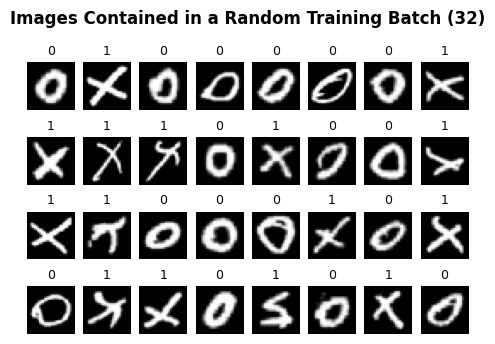

In [8]:
# generate random index
idx = np.random.randint(low=0, high=len(train_dl))
# get random batch
rand_x_batch, rand_y_batch = list(train_dl)[idx] # convert batch to list, access via index

# declare figure and subplots
f, axs = plt.subplots(4, 8, figsize=(4.5, 4.5), layout='compressed')
# plot
for i, ax in enumerate(axs.flat):
  ax.set_title(rand_y_batch[i].item(), fontsize=9)
  ax.axis(False)
  ax.imshow(rand_x_batch[i].squeeze(), cmap='gray')
# suptitle
f.suptitle('Images Contained in a Random Training Batch (32)',
             weight='black',
             y=0.9) #suptitle position
plt.show()

### Define model, optimizer, loss function
> Here, we'll define a model, optimize and loss function with the help of the `model_builder.py` module

In [9]:
model, opt, loss_fn = model_builder.get_model(device)

#### Visualize structure of neural network
> We'll do this using the [`torchinfo`](https://github.com/TylerYep/torchinfo) library

In [10]:
# install torchinfo
!pip install torchinfo
from torchinfo import summary

In [11]:
# visualize model structure
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 128, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─BatchNorm2d: 2-2                  [1, 64, 28, 28]           128
│    └─ReLU: 2-3                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 128, 28, 28]          73,856
│    └─BatchNorm2d: 2-5                  [1, 128, 28, 28]          256
│    └─ReLU: 2-6                         [1, 128, 28, 28]          --
│    └─MaxPool2d: 2-7                    [1, 128, 14, 14]          --
├─Sequential: 1-2                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-8                       [1, 256, 14, 14]          295,168
│    └─BatchNorm2d: 2-9                  [1, 256, 14, 14]          512
│    └─ReLU: 2-10                        [1, 256, 14, 14]          --
│ 

### Early stopping
> 💎 **Pro Tip**

> [Early stopping](https://www.linkedin.com/advice/1/what-benefits-drawbacks-early-stopping#:~:text=Early%20stopping%20is%20a%20form,to%20increase%20or%20stops%20improving.) is a mechanism of stopping training when the validation loss stops improving; with a view to preventing _overfitting_ on the training data
+ Here, I'll define an object of `EarlyStopping` class from `utils.py`

In [12]:
# earlystopping object
est = utils.EarlyStopping(score_type='metric', patience=3)

### Model training
> Here, we'll define an optimization loop to train and evaluate the model
+ We'll make use of the `train_batches` and `test_batches` functions defined in `train_test.py` module

In [13]:
%%time
# lists to keep progress of training / testing values
train_loss, test_loss, train_f1, test_f1, train_acc, test_acc, ep_list = [],\
    [], [], [], [], [], [],
# epochs
epochs = 10

for ep in range(1, epochs+1):
  ep_list.append(ep)

  # train
  tr_loss, tr_acc, tr_f1 = train_test.train_batches(model, train_dl, opt, loss_fn, device)
  # append values to list
  train_loss.append(tr_loss), train_acc.append(tr_acc), train_f1.append(tr_f1)

  # test
  ts_loss, ts_acc, ts_f1 = train_test.test_batches(model, test_dl, loss_fn, device)
  test_loss.append(ts_loss), test_acc.append(ts_acc), test_f1.append(ts_f1)

  # early stopping
  est(model=model, ep=ep, ts_score=ts_f1) # evaluate for each epoch
  if est.stop_early:
    break

  if ep%2 == 0:
    print(f'Epoch: {ep}\n----------')
    print(f'Train Loss: {tr_loss:.3f} | Test Loss: {ts_loss:.3f}')
    print(f'Train Accuracy: {tr_acc:.3f} | Test Accuracy: {ts_acc:.3f}')
    print(f'Train F1-Score: {tr_f1:.3f} | Test F1-Score: {ts_f1:.3f}\n')

# print best results
print(f'STOPPED | Best Epoch: {est.best_epoch} | Best Loss: {est.best_score:.3f}')

Epoch: 2
----------
Train Loss: 0.022 | Test Loss: 0.017
Train Accuracy: 0.996 | Test Accuracy: 0.994
Train F1-Score: 0.996 | Test F1-Score: 0.994

Epoch: 4
----------
Train Loss: 0.014 | Test Loss: 0.014
Train Accuracy: 0.998 | Test Accuracy: 0.994
Train F1-Score: 0.998 | Test F1-Score: 0.994

Epoch: 6
----------
Train Loss: 0.011 | Test Loss: 0.012
Train Accuracy: 0.998 | Test Accuracy: 0.995
Train F1-Score: 0.998 | Test F1-Score: 0.995

Epoch: 8
----------
Train Loss: 0.009 | Test Loss: 0.011
Train Accuracy: 0.999 | Test Accuracy: 0.996
Train F1-Score: 0.999 | Test F1-Score: 0.996

Epoch: 10
----------
Train Loss: 0.008 | Test Loss: 0.010
Train Accuracy: 0.999 | Test Accuracy: 0.996
Train F1-Score: 0.999 | Test F1-Score: 0.996

STOPPED | Best Epoch: 10 | Best Loss: 0.996
CPU times: user 49.3 s, sys: 2.92 s, total: 52.3 s
Wall time: 1min 6s


In [14]:
# overwrite the model parameters with best parameters from earlystopping
model.load_state_dict(est.best_state_dict)

<All keys matched successfully>

#### Get `y_pred` and `y_proba`
+ I'll make use of the `get_preds_proba` function defined in `train_test.py` module



In [15]:
%%time
y_pred, y_proba = train_test.get_preds_proba(model, test_dl, device)

# confirm the size of both
y_pred.shape, y_proba.shape

CPU times: user 190 ms, sys: 77.8 ms, total: 268 ms
Wall time: 407 ms


((1600,), (1600, 2))

### Model evaluation
> Here, I'll evaluate the model by plotting results from the optimization loop, as well as evaluating it on basis of classification metrics  

> ✋ **Info**
+ I'll be using [`scikit-learn`](https://scikit-learn.org/stable/index.html) [classification metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#classification-metrics)

#### Plot optimization results
+ I'll use the `plot_train_results` function defined in `utils.py` module

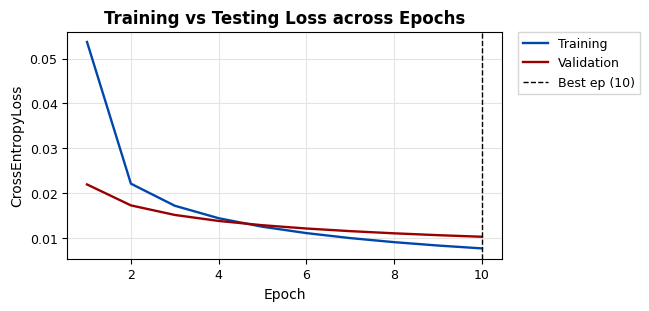

In [16]:
# training vs testing loss
utils.plot_train_results(ep_list=ep_list, train_score=train_loss, test_score=test_loss,
                   ylabel='CrossEntropyLoss',
                   title='Training vs Testing Loss across Epochs',
                   best_epoch=est.best_epoch)

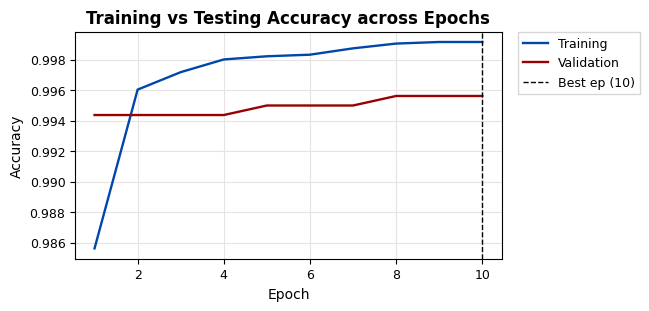

In [17]:
# training vs testing accuracy
utils.plot_train_results(ep_list=ep_list, train_score=train_acc, test_score=test_acc,
                   ylabel='Accuracy',
                   title='Training vs Testing Accuracy across Epochs',
                   best_epoch=est.best_epoch)

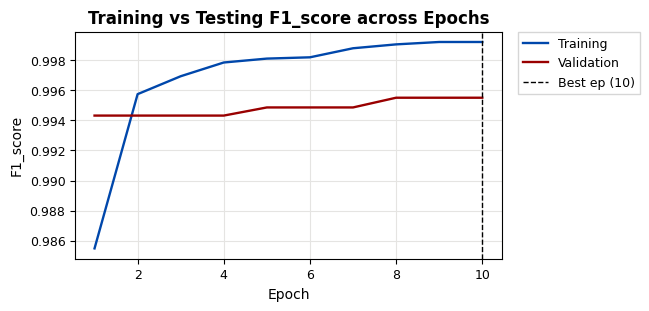

In [18]:
# training vs testing f1_scores
utils.plot_train_results(ep_list=ep_list, train_score=train_f1, test_score=test_f1,
                   ylabel='F1_score',
                   title='Training vs Testing F1_score across Epochs',
                   best_epoch=est.best_epoch)

#### [`accuracy`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)

In [19]:
from sklearn.metrics import accuracy_score

# calculate
acc = accuracy_score(y_true=y_true, y_pred=y_pred)
# print
print(f'Model accuracy: {acc:.4f}')

Model accuracy: 0.9956


#### [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

In [20]:
from sklearn.metrics import f1_score

# calculate
f1 = f1_score(y_true=y_true, y_pred=y_pred)
# print
print(f'F1_score: {f1:.4f}')

F1_score: 0.9956


#### [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)

In [21]:
from sklearn.metrics import classification_report

# calculate
cr = classification_report(y_true=y_true, y_pred=y_pred)
# print
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      0.99      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



#### [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

In [22]:
from sklearn.metrics import roc_auc_score
# calculate
ras = roc_auc_score(y_true=y_true,
                    y_score=y_proba[:, 1])
# print
print(f'roc_auc_score: {ras:.3f}')

roc_auc_score: 1.000


#### [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)
+ `plot_confusion_matrix` function from the `utils.py` module will help plot a `confusion_matrix`

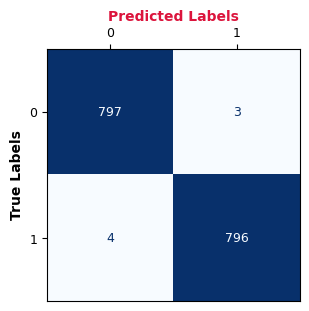

In [23]:
utils.plot_confusion_matrix(y_true=y_true, y_pred=y_pred)

### Save model
+ Here, I'll make use of the `save_model` function from the `utils.py` module

In [24]:
# make a parent directory
PARENT = Path('models')
PARENT.mkdir(parents=True, exist_ok=True)

# model directory
MODEL_PATH = PARENT/'XO.pth'

# view model path
print(f'Model path: {MODEL_PATH}')

Model path: models/XO.pth


In [25]:
# save
utils.save_model(model=model, path=MODEL_PATH)

MODEL'S state_dict SAVED TO: models/XO.pth


#### Load saved model
+ Here, we'll use the `load_model` function defined in `utils.py`

In [26]:
# first, create an object of the model class
loaded_model, _, _ = model_builder.get_model(device)

# load
utils.load_model(model=loaded_model, path=MODEL_PATH)

### Make inference
> Here, we'll make inference:
+ On a single random data sample
+ On multiple `(12)` random data samples

#### Make inference on single image
> Using `make_single_inference` in `utils.py` module

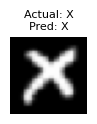

In [27]:
utils.make_single_inference(loaded_model, test_dl.dataset, label_map, device)

#### Making inference on multiple images
> Using `make_multiple_inference` in `utils.py` module

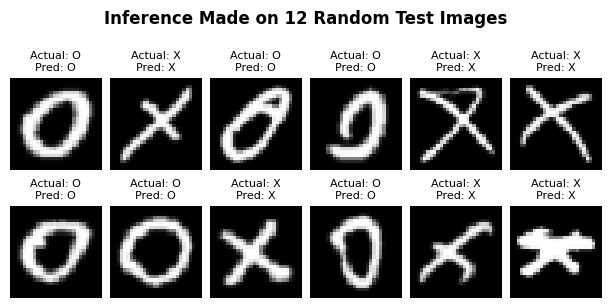

In [28]:
utils.make_multiple_inference(loaded_model, test_dl.dataset, label_map, device)

### Conclusion

> 📈 **Results**  

> Based on the overall classification metrics, the model we've trained in this notebook - a tweaked version of [`TinyVGG`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), performs impeccably
+ Notably however, this was an extremely simple binary classification task, and both classes, `0` and `1` were balanced

> We were able to achieve the following (on a scale of `0` -> `1`):
+ A weighted `precision`, `recall` and `f1_score` of `1.00`
+ An overall model accuracy of `0.9956`
+ An overall `roc_auc_score` of `1.00`

> Until next time, happy coding! 👋